# Detecting Drivers of Anomalous Backscattering with Multiple Regression 

This notebooks show how to deal with big EO datasets in studies that apply regression analysis. In this study we want to better understand the causes of "anomalous" backscattering of Sentinel-1 microwaves from soils. Anomalous backscattering contrasts with the situation where microwaves recorded by Sentinel-1 sensors are governed by the soil's moisture content. The latter "normal" backscattering behavior is governed by the dielectric contrast at the air--soil interface in wet soils [1]. The cause of anomalous backscattering is less well-known but is generally thought to relate to deeper penetration of microwaves in dry soils and volume scattering effects by the presence of rocks or distinct horizons in soils [2, 3].

Hence we want to identify what factors might cause


In [16]:
%matplotlib inline

from pathlib import Path

import xarray as xr
import numpy as np
import dask.dataframe as dd

from sklearn.linear_model import SGDRegressor
from dask_ml.wrappers import Incremental
from dask_ml.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dask Dataframe

In [2]:
soil_df = dd.read_parquet("data/S1_ERA5L_CRRL/CRRL-SIG0-ERA5L/V1M0R1/EQUI7_OC020M")
soil_df

,y,x,depth,spatial_ref,band,rsub,cfg,sm
npartitions=90,,,,,,,,
,float64,float64,string,int64,int64,float32,int8,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


## Visualize Data

For this analysis we want to explain the causes of anomalous backscattering quantified with the metric `rsub` at 20 meter resolution. This is a temporal correlation between Sentinel-1 backscatter timeseries and reference soil moisture data from [ERA5Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land) provided by the European Center for Medium-Range Weather Forecasts (ECMWF) at 9 km resolution. In an attempt to explain anomalies in backscatter data we use the long term dryness of soils as measured by the mean soil moisture content over the last 30 years based on ERA5Land soil moisture data and the coarse fragment content of the soil from the Soil and Landscape Grid of Australia (SLGA) at a 90 meter resolution.

First let's have a look at some of the data. We convert the parquet datatype to an xarray for some convenient visualization of the data.


In [3]:
soil_dc = soil_df.partitions[0:10].compute().set_index(["depth", "y", "x", "spatial_ref"])\
    .to_xarray().squeeze("spatial_ref")
soil_dc["rsub"] = soil_dc.rsub.mean("depth", skipna=True)
soil_dc

<xarray.Dataset> Size: 553MB
Dimensions:      (depth: 2, y: 3489, x: 4170)
Coordinates:
  * depth        (depth) object 16B '000_005' '005_030'
  * y            (y) float64 28kB -34.09 -34.09 -34.09 ... -31.19 -31.19 -31.19
  * x            (x) float64 33kB 117.7 117.7 117.7 117.7 ... 121.2 121.2 121.2
    spatial_ref  int64 8B 0
Data variables:
    band         (depth, y, x) int64 233MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    rsub         (y, x) float32 58MB nan nan nan nan nan ... nan nan nan nan nan
    cfg          (depth, y, x) int8 29MB 1 1 1 1 1 1 1 1 1 ... 1 2 2 1 2 2 1 2 2
    sm           (depth, y, x) float64 233MB 0.2149 0.2149 0.2149 ... nan nan

We start with the anomaly detection metric `rsub`. We can plot the data along the x-y coordinates as a map by using the `plot` method.

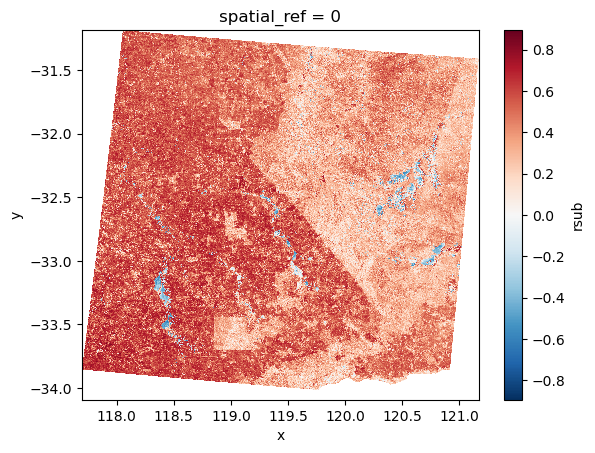

In [4]:
soil_dc.rsub.plot()

The soil properties have three dimensions we can visualize these variables on maps by facetting the depth dimension using the `col` argument.

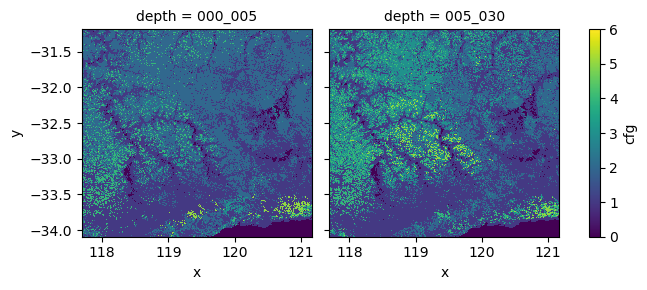

In [5]:
soil_dc.cfg.plot(col="depth")

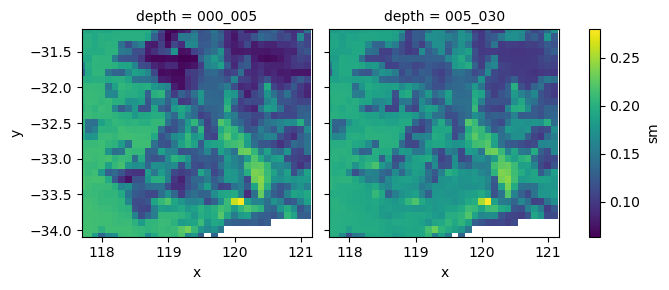

In [6]:
soil_dc.sm.plot(col="depth")

## Data Preprocessing

We will be using a stochastic gradient decent model, where we want to explain `rsub` with two explanatory variables `sm` and `cfg`. This multiple regression model can be formulated as follows;

$$ rsub = \beta_0 + \beta_1 sm + \beta_2 cfg $$

, where we want to find suitable values for the coefficients $\beta_0$ (or intercept) and the partial slopes $\beta_1$ and $\beta_2$.

In [7]:
EXP_VARIABLES = ["sm", "cfg"]
RES_VARIABLE = "rsub"


For this exercise we will onl;y use the upper depth interval of the soil properties. We therefore filter our Dask Dataframe, as follows:


In [8]:
soil_df = soil_df[soil_df.depth=="000_005"]
soil_df

,y,x,depth,spatial_ref,band,rsub,cfg,sm
npartitions=90,,,,,,,,
,float64,float64,string,int64,int64,float32,int8,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


The model cannot deal with `nan` values, so we have to filter out all those observations including a `nan` for continuous variables and `0` for integers from both the response and explanatory variables.

In [9]:
soil_df = soil_df.dropna()
soil_df = soil_df[soil_df.cfg != 0]
soil_df

,y,x,depth,spatial_ref,band,rsub,cfg,sm
npartitions=90,,,,,,,,
,float64,float64,string,int64,int64,float32,int8,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [10]:
def cull_empty_partitions(df):
    ll = list(df.map_partitions(len).compute())
    df_delayed = df.to_delayed()
    df_delayed_new = list()
    pempty = None
    for ix, n in enumerate(ll):
        if 0 == n:
            pempty = df.get_partition(ix)
        else:
            df_delayed_new.append(df_delayed[ix])
    if pempty is not None:
        df = dd.from_delayed(df_delayed_new, meta=pempty)
    return df

soil_df = cull_empty_partitions(soil_df)

## Interactions

In the model we would be interested not only in the effect of the single explanatory variables on the response, but also the interactions of e.g. coarse fragments in the soil and the overall wetness of soils. This includes the effect that dry soil allow deeper penetration of microwaves that can results in volume scattering by stone and rock fragments at depth.

Hence we include a interaction in the regressors, by multiplying `sm` with `cfg`, like so:

In [11]:
def make_interaction(df, x ,y):
    new = x + "_" + y
    df[new] = df[x] * df[y]
    if new not in EXP_VARIABLES:
        EXP_VARIABLES.append(new)
    return df

soil_df = make_interaction(soil_df, "sm", "cfg")
soil_df

,y,x,depth,spatial_ref,band,rsub,cfg,sm,sm_cfg
npartitions=85,,,,,,,,,
,float64,float64,string,int64,int64,float32,int8,float64,float64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


## Modelling with Dask-ML

Now we can start to construct the SGD regression model.

In [12]:
model = SGDRegressor()
dask_model = Incremental(model, scoring='neg_mean_squared_error')

Fitting the model to X and y gives as expected three coefficients

In [13]:
dask_fit = dask_model.fit(soil_df[EXP_VARIABLES], soil_df[RES_VARIABLE])

In [17]:
from IPython.display import display, Math
display(Math(r'rsub = {0:} {1:+}sm {2:+}cfg {3:+}sm \times cfg'.format(*tuple(round(i, 2) for i in np.append(dask_fit.intercept_, dask_fit.coef_)))))

<IPython.core.display.Math object>

We can alaso check how much variance in the response is explaimned by this model. Using the coefficient of determination or R2. For this we first have to predict the response given X, like so:

In [18]:
predict = dask_fit.predict(soil_df[EXP_VARIABLES])

In [27]:
soil_df["predict"] = predict
# soil_df.compute().plot(x="rsub", y="predict")
# truth = soil_df[RES_VARIABLE].to_dask_array()

: 

And calculate the R2:

In [23]:
r2_score(truth, predict)
# import dask.array as da
# r2_score(truth[~da.isnan(truth).compute()], predict[~da.isnan(predict).compute()])

ValueError: cannot convert float NaN to integer

## Predictor Effect Plot

Let's nop construct predictor effects plots with partial fits of the regression model to investigate the effect of the individual regressors on the response `rsub`. We first have to create some dummy data to predict the response given a single regressor while keeping the order regressors fixed.

In [20]:
import numpy as np
import pandas as pd
def make_new_data(target, fixed):
    vals = list(*target.values())
    df = pd.DataFrame({list(target.keys())[0]: np.linspace(vals[0], vals[1], num=50, dtype=vals[0].dtype)})
    for name, value in fixed.items():
        df[name] = np.repeat(value, repeats=50)
    return df

This data can then be fed to the model

In [21]:
def partial_fit_(target, fixed, model, interactions):
    new_df = make_new_data(target, fixed)
    for i in interactions:
        new_df = make_interaction(new_df, i[0], i[1])
    new_df["predict"] = model.predict(new_df[EXP_VARIABLES])
    return new_df

def partial_fit(target, fixed, model, interactions):
    fitted_data = []
    for i in list(*fixed.values()):
        fitted_data.append(partial_fit_(target, {list(fixed.keys())[0]: i}, model, interactions))
    return pd.concat(fitted_data)


yielding the following result when fixing soil moisture content to ..:

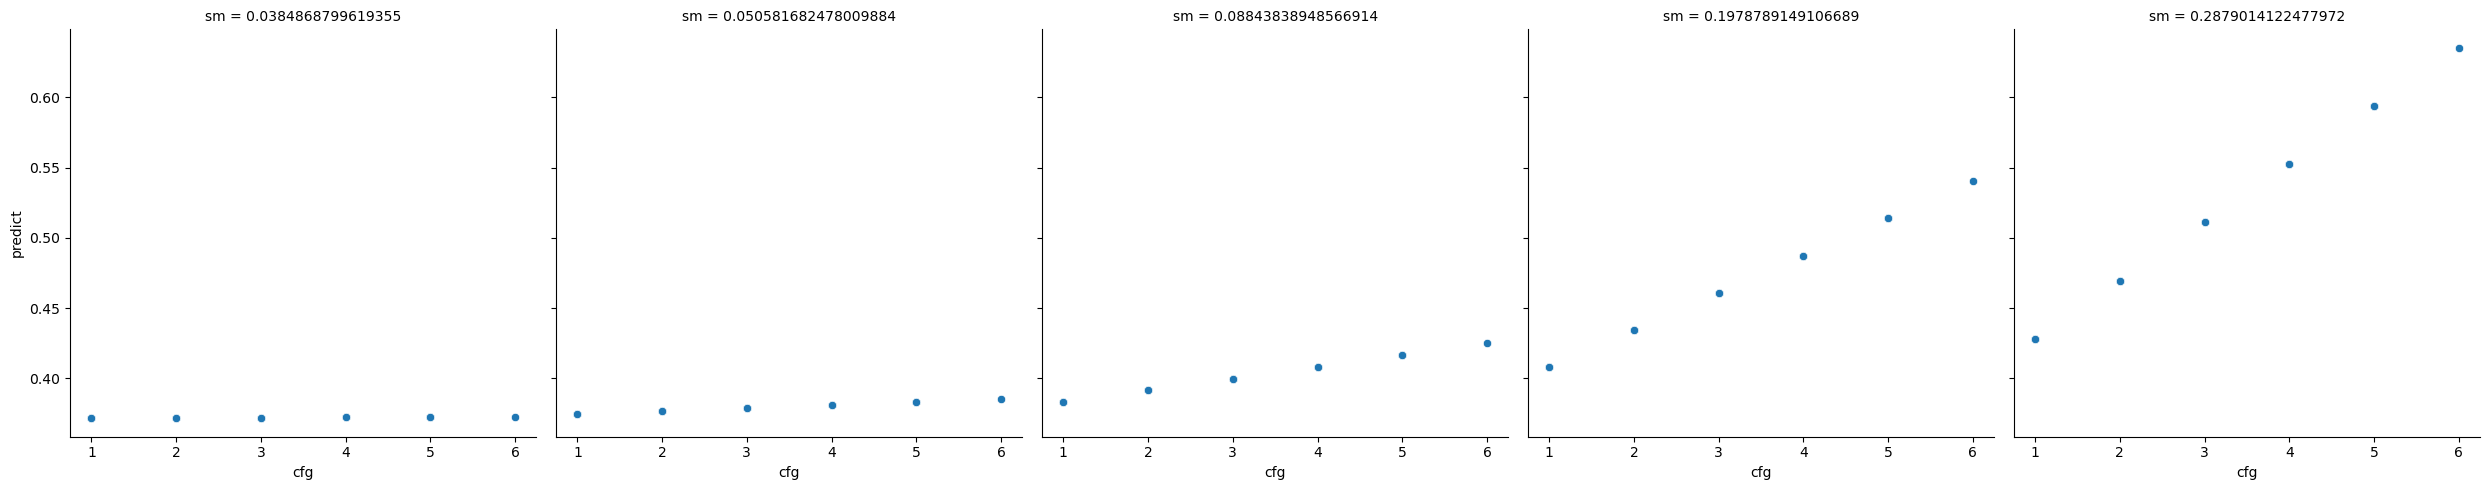

In [22]:
partial_sm = partial_fit(
    {"cfg": (soil_df["cfg"].min().compute(), soil_df["cfg"].max().compute())}, 
    {"sm": np.quantile(soil_df["sm"], [0.05, 0.25, 0.5, 0.75, 0.95])}, 
    dask_fit,
    [("sm", "cfg")]
)

sns.relplot(
    data=partial_sm,
    x="cfg", 
    y="predict",
    col="sm",
)